In [4]:
import numpy as np
import cv2
import os

from matplotlib_helper import imshow

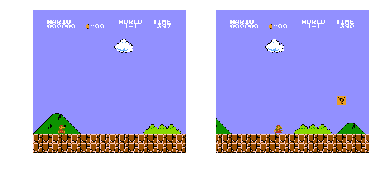

In [5]:
imageFolder = 'images'
extension = 'png'
imageFileLeft = '{}/Super Mario Bros (E)_002.{}'.format(imageFolder, extension)
imageFileRight = '{}/Super Mario Bros (E)_003.{}'.format(imageFolder, extension)

imageLeft = cv2.imread(imageFileLeft)[:,:,::-1]
imageRight = cv2.imread(imageFileRight)[:,:,::-1]

imshow(imageLeft, imageRight)

In [128]:
def perspectiveStitch(imageLeft, imageRight):
    orb = cv2.ORB_create()
    kpLeft, desLeft = orb.detectAndCompute(imageLeft, None)
    kpRight, desRight = orb.detectAndCompute(imageRight, None)

    imageLeftKp = cv2.drawKeypoints(imageLeft, kpLeft, None, color=(0,255,0), flags=0)
    imageRightKp = cv2.drawKeypoints(imageRight, kpRight, None, color=(0,255,0), flags=0)
    
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(desLeft, desRight)
    
    ptsA = np.float32([kpLeft[i.queryIdx].pt for i in matches])
    ptsB = np.float32([kpRight[i.trainIdx].pt for i in matches])

    homographyMatrix, __ = cv2.findHomography(ptsB, ptsA, cv2.RANSAC, 4)    
    warpedImage = cv2.warpPerspective(imageRight, homographyMatrix, (imageLeft.shape[1]+imageRight.shape[1], imageLeft.shape[0]))
    warpedImage[:, 0:imageLeft.shape[1], :] = imageLeft
    
    w2,h2 = imageRight.shape[:2]
    imageRightTempDim = np.float32([ [0,0], [0,w2], [h2, w2], [h2,0] ]).reshape(-1,1,2)
    imageRightDim = cv2.perspectiveTransform(imageRightTempDim, homographyMatrix)
    rightEdge = int(np.min(imageRightDim[2:].T[0]))
    return warpedImage[:, :rightEdge, :]

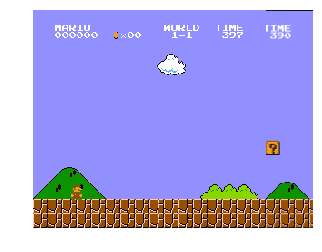

In [129]:
stitchedImage = perspectiveStitch(imageLeft, imageRight)
imshow(stitchedImage)

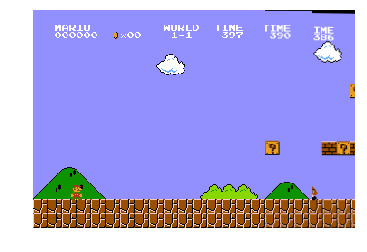

In [130]:
imageFileRight2 = '{}/Super Mario Bros (E)_004.{}'.format(imageFolder, extension)
imageRight2 = cv2.imread(imageFileRight2)[:,:,::-1]

stitchedImage2 = perspectiveStitch(stitchedImage, imageRight2)
imshow(stitchedImage2)

In [131]:
def affineStitch(imageLeft, imageRight):
    orb = cv2.ORB_create()
    kpLeft, desLeft = orb.detectAndCompute(imageLeft, None)
    kpRight, desRight = orb.detectAndCompute(imageRight, None)

    imageLeftKp = cv2.drawKeypoints(imageLeft, kpLeft, None, color=(0,255,0), flags=0)
    imageRightKp = cv2.drawKeypoints(imageRight, kpRight, None, color=(0,255,0), flags=0)
    
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(desLeft, desRight)
    
    goodMatches = []
    for m in matches:
        if m.distance < 5:
            goodMatches.append(m)
    
#     imageCorrespondence = cv2.drawMatches(imageLeft, kpLeft, imageRight, kpRight, goodMatches, None, flags=2)
#     imshow(imageCorrespondence)
    
    ptsA = np.float32([kpLeft[i.queryIdx].pt for i in goodMatches])
    ptsB = np.float32([kpRight[i.trainIdx].pt for i in goodMatches])
    
    M = cv2.getAffineTransform(ptsB[:3],ptsA[:3])
    warpedImage = cv2.warpAffine(imageRight,M,(imageLeft.shape[1]+imageRight.shape[1],imageLeft.shape[0]))
    warpedImage[:, 0:imageLeft.shape[1], :] = imageLeft
    
    homographyMatrix = np.eye(3)
    homographyMatrix[0,2] = M[0,2]
    homographyMatrix[1,2] = M[1,2]
    
    w2,h2 = imageRight.shape[:2]
    imageRightTempDim = np.float32([ [0,0], [0,w2], [h2, w2], [h2,0] ]).reshape(-1,1,2)
    imageRightDim = cv2.perspectiveTransform(imageRightTempDim, homographyMatrix)
    rightEdge = int(np.min(imageRightDim[2:].T[0]))
    return warpedImage[:, :rightEdge, :]


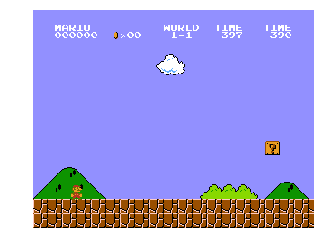

In [132]:
stitchedImage = affineStitch(imageLeft, imageRight)
imshow(stitchedImage)

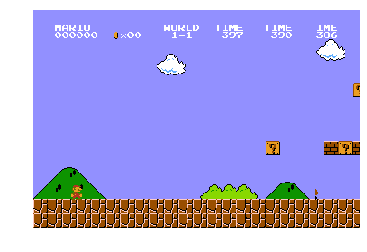

In [133]:
stitchedImage2 = affineStitch(stitchedImage, imageRight2)
imshow(stitchedImage2)

In [135]:
cv2.imwrite('stitchedimage.png', stitchedImage2)

True